In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from random import choices
rng = np.random
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
from sklearn.preprocessing import label_binarize
import itertools
from scipy import interp
from scipy.stats import mode
print(tf.__version__)
import time
from sklearn.preprocessing import scale

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.10.0


In [2]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [3]:
# Read in data from small csv to a dataframe
df1=pd.read_csv('weather_medium.csv', sep=',')

# Reformat data in date/time column 
df1['Formatted Date'] =  pd.to_datetime(df1['Formatted Date'])

# Create a new column for year / month / hour
df1['Year'] = pd.DatetimeIndex(df1['Formatted Date']).year
df1['Month'] = pd.DatetimeIndex(df1['Formatted Date']).month
df1['Hour'] = pd.DatetimeIndex(df1['Formatted Date']).hour

# Encode month and hour for cyclical nature
df1 = encode(df1, 'Month', 13)
df1 = encode(df1, 'Hour', 23)
df1 = encode(df1, 'Wind Bearing (degrees)', 359)

# Remove original date/time column
df1=df1.drop(['Formatted Date'],axis=1)

# Convert columns to factors
df1['Summary'] = df1['Summary'].astype('category')
df1['Precip Type'] = df1['Precip Type'].astype('category')
df1['Daily Summary'] = df1['Daily Summary'].astype('category')

# Create a column stating whether its mostly cloudy / overcast or not in summary
df1['Heavy_Cloud'] = pd.np.where(df1.Summary.str.contains("Mostly Cloudy"), 1,
                    pd.np.where(df1.Summary.str.contains("Overcast"), 1,
                    pd.np.where(df1.Summary.str.contains("Foggy"), 1,0)))

# Convert to boolean and print count
df1['Heavy_Cloud']=df1['Heavy_Cloud'].astype('bool')

In [4]:
y = df1['Heavy_Cloud']
X=scale(df1[['Temperature (C)','Apparent Temperature (C)','Humidity','Wind Speed (km/h)','Month_cos','Visibility (km)']])
X = pd.DataFrame(data=X)

y_new = np.zeros((len(y), 2))
for i in range(0, len(y)):
    elem = y[i]
    arr = [0,0]
    arr[elem] = 1
    y_new[i] = arr 

num = len(df1)
indices = list(range(num))
split = int(max(indices)*0.1)

test_idx = np.random.choice(indices, size=split, replace=False)

inter_idx = list(set(indices) - set(test_idx))

num = len(inter_idx)
indices = list(range(num))
split = int(max(indices)*0.22)

valid_idx = np.random.choice(inter_idx, size=split, replace=False)
train_idx = list(set(inter_idx) - set(valid_idx))

x_train = np.array(X.loc[train_idx,:], dtype=np.float32)
# x_train = x_train.reshape(-1, 1)

y_train = np.array(y[train_idx], dtype=np.float32)
y_new_train = np.array(y_new[train_idx], dtype=np.float32)
# y_train = y_train.reshape(-1, 1)

x_valid = np.array(X.loc[valid_idx,:], dtype=np.float32)
# x_valid = x_valid.reshape(-1, 1)

y_valid = np.array(y[valid_idx], dtype=np.float32)
y_new_valid = np.array(y_new[valid_idx], dtype=np.float32)
# y_valid = y_valid.reshape(-1, 1)

x_test = np.array(X.loc[test_idx,:], dtype=np.float32)
# x_test = x_test.reshape(-1, 1)

y_test = np.array(y[test_idx], dtype=np.float32)
y_new_test = np.array(y_new[test_idx], dtype=np.float32)
# y_test = y_test.reshape(-1, 1)

print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(df1),2),
                                                       round(len(y_valid)/len(df1),2),
                                                       round(len(y_test)/len(df1),2)))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  if __name__ == '__main__':


train: 0.7% | validation: 0.2% | test 0.1%


In [5]:
# Declare feature for model and hyperparameter
batch_size = 1000
W = tf.Variable(tf.zeros([6, 2]))
b = tf.Variable(tf.zeros([2]))

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
# Variable for model
data = tf.placeholder(dtype=tf.float32, shape=[None, 6])
target = tf.placeholder(dtype=tf.float32, shape=[None, 2])

mod = tf.nn.softmax(tf.matmul(data, W) + b)
loss = loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=mod, labels=target))

learning_rate = 0.01

iter_num = 10000
opt = tf.train.GradientDescentOptimizer(learning_rate)

goal = opt.minimize(loss)

prediction = tf.round(mod)
correct = tf.cast(tf.equal(prediction, target), dtype=tf.float32)
accuracy =  tf.reduce_mean(correct)

In [6]:
loss_trace = []
train_acc = []
test_acc = []
# training model

start_time = time.clock()
for epoch in range(iter_num):
    # Generate random batch index
    batch_index = np.random.choice(len(x_train), size=batch_size)
    batch_train_X = x_train[batch_index]
    batch_train_y = y_new_train[batch_index]
    sess.run(goal, feed_dict={data: batch_train_X, target: batch_train_y})
    temp_loss = sess.run(loss, feed_dict={data: batch_train_X, target: batch_train_y})
    # convert into a matrix, and the shape of the placeholder to correspond
    # temp_train_acc = sess.run(accuracy, feed_dict={data: x_train, target: y_new_train})
    # temp_test_acc = sess.run(accuracy, feed_dict={data: x_valid, target: y_new_valid})
    # recode the resultx
    # loss_trace.append(temp_loss)
    # train_acc.append(temp_train_acc)
    # test_acc.append(temp_test_acc)

    #if (epoch + 1) % 300 == 0:
        #print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                          #temp_train_acc, temp_test_acc))
print (time.clock() - start_time, "seconds")

16.736053 seconds


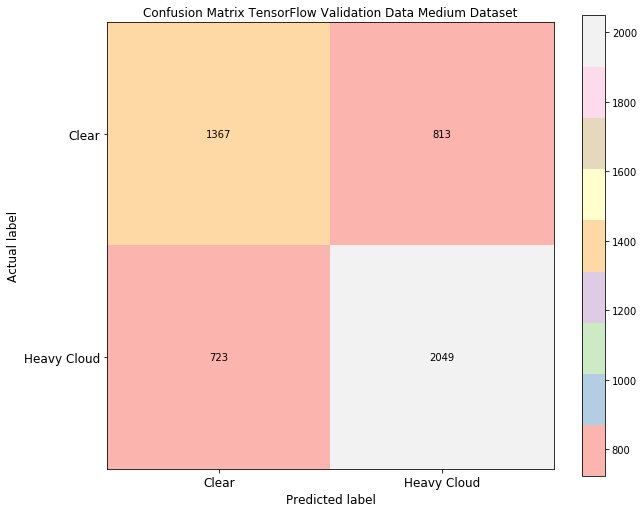

In [7]:
# Confusion Matrix
feed_dict = {data: x_valid}
# print(y_valid)
#print(X)
predictions = sess.run(tf.argmax(mod, -1), feed_dict=feed_dict)

# Confusion Matrix
cm = metrics.confusion_matrix(y_valid, predictions)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion Matrix TensorFlow Validation Data Medium Dataset', size = 12)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Clear", "Heavy Cloud"], size = 12)
plt.yticks(tick_marks, ["Clear", "Heavy Cloud"], size = 12)
plt.tight_layout()
plt.ylabel('Actual label', size = 12)
plt.xlabel('Predicted label', size = 12)
width, height = cm.shape
for x in range(width):
 for y in range(height):
  plt.annotate(str(cm[x][y]), xy=(y, x), 
  horizontalalignment='center',
  verticalalignment='center')

plt.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7 ,wspace=0.5)
plt.savefig('Logistic_Regression_Validation_Confusion_Medium_TF.png',pdi=600)

In [8]:
accuracy=sum(predictions==y_valid)/len(predictions)

ERR=1-accuracy
Recall = (cm[0,0])/(np.sum(cm,axis=1)[0])
FPR=(cm[1,0])/(np.sum(cm,axis=1)[1])
Specificity=1-FPR
FNR=1-Recall

print('Score of validation model: ',accuracy)
print('Error rate of validation model: ',ERR)
print('Recall / TPR of validation model: ',Recall)
print('FNR of validation model: ',FNR)
print('Specificity / TNR of validation model: ',Specificity)
print('FPR of validation model: ',FPR)

Score of validation model:  0.6898222940226171
Error rate of validation model:  0.3101777059773829
Recall / TPR of validation model:  0.6270642201834863
FNR of validation model:  0.3729357798165137
Specificity / TNR of validation model:  0.7391774891774892
FPR of validation model:  0.26082251082251084


AUC of validation model 0.6831208546804877


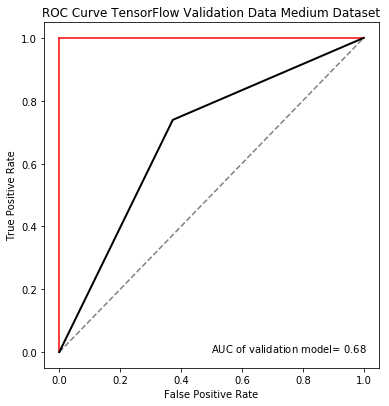

In [9]:
### calculate ROC Score
print("AUC of validation model",roc_auc_score(y_valid, predictions))
fpr, tpr, _ = metrics.roc_curve(y_valid, predictions)

fig, ax1=plt.subplots(figsize=(6,6))
x1 = [0, 0]
x2 = [0,1]
y1=[0,1]
y2=[1,1]
ax1.plot(x1, y1, 'red')
ax1.plot(x2, y2, 'red')
ax1.plot(x2, y1, 'grey',linestyle='--')

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve TensorFlow Validation Data Medium Dataset')
ax1.plot(fpr,tpr,color='Black',linewidth=2,label='ROC Curve')

textstr = 'AUC of validation model= $%.2f$'%(roc_auc_score(y_valid, predictions))
ax1.text(0.5,0,textstr)

fig.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7 ,wspace=0.5)
fig.savefig('Logistic_Regression_Validation_ROC_Medium_TF.png',pdi=600)

In [10]:
# Confusion Matrix
feed_dict = {data: x_test}
# print(y_valid)
#print(X)
predictions_test = sess.run(tf.argmax(mod, -1), feed_dict=feed_dict)



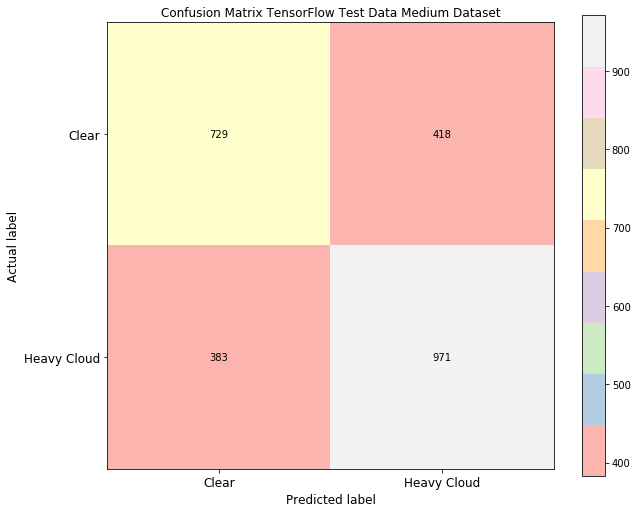

In [11]:
# Confusion Matrix
cm2 = metrics.confusion_matrix(y_test, predictions_test)
plt.figure(figsize=(10,8))
plt.imshow(cm2, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion Matrix TensorFlow Test Data Medium Dataset', size = 12)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Clear", "Heavy Cloud"], size = 12)
plt.yticks(tick_marks, ["Clear", "Heavy Cloud"], size = 12)
plt.tight_layout()
plt.ylabel('Actual label', size = 12)
plt.xlabel('Predicted label', size = 12)
width, height = cm2.shape
for x in range(width):
 for y in range(height):
  plt.annotate(str(cm2[x][y]), xy=(y, x), 
  horizontalalignment='center',
  verticalalignment='center')

plt.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7 ,wspace=0.5)
plt.savefig('Logistic_Regression_Test_Confusion_Medium_TF.png',pdi=600)

In [12]:
accuracy=sum(predictions_test==y_test)/len(predictions_test)
ERR=1-accuracy

FPR=(cm2[1,0])/(np.sum(cm2,axis=1)[1])
Specificity=1-FPR
Recall = (cm2[0,0])/(np.sum(cm2,axis=1)[0])
FNR=1-Recall

print('Score of test model: ',accuracy)
print('Error rate of test model: ',ERR)
print('Recall / TPR of test model: ',Recall)
print('FNR of test model: ',FNR)
print('Specificity / TNR of test model: ',Specificity)
print('FPR of test model: ',FPR)

Score of test model:  0.6797281087564974
Error rate of test model:  0.32027189124350264
Recall / TPR of test model:  0.6355710549258936
FNR of test model:  0.3644289450741064
Specificity / TNR of test model:  0.7171344165435746
FPR of test model:  0.28286558345642543


AUC of validation model 0.6763527357347341


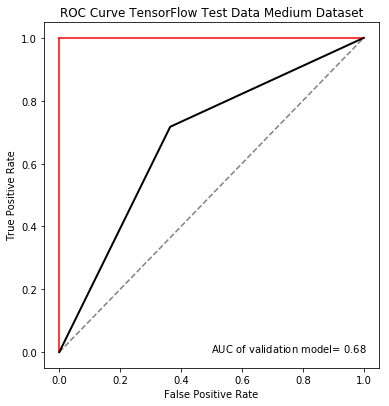

In [13]:
### calculate ROC Score
print("AUC of validation model",roc_auc_score(y_test, predictions_test))
fpr, tpr, _ = metrics.roc_curve(y_test, predictions_test)

fig, ax1=plt.subplots(figsize=(6,6))
x1 = [0, 0]
x2 = [0,1]
y1=[0,1]
y2=[1,1]
ax1.plot(x1, y1, 'red')
ax1.plot(x2, y2, 'red')
ax1.plot(x2, y1, 'grey',linestyle='--')

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve TensorFlow Test Data Medium Dataset')
ax1.plot(fpr,tpr,color='Black',linewidth=2,label='ROC Curve')

textstr = 'AUC of validation model= $%.2f$'%(roc_auc_score(y_test, predictions_test))
ax1.text(0.5,0,textstr)

fig.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7 ,wspace=0.5)
fig.savefig('Logistic_Regression_Test_ROC_Medium_TF.png',pdi=600)